In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, prange

import sys

sys.path.append('../modules/')

import funAdapt as fa

In [3]:
Nsteps = int(5e2)
dt = 1e-3

sigma = 1.5
theta_eta = 3.
tau_a = 1.
sigma_a = 0.1
Lambda = 0.9

amean = 1.36585


L, _, _, _, S, I, afluct = fa.find_functional_afluc(Nsteps, dt, sigma, amean, tau_a, sigma_a, theta_eta, Lambda, x0 = 0, y0 = 0, eta0 = 0, tau_x = 1, theta_y = 1)

In [4]:
L

0.24570286337808467

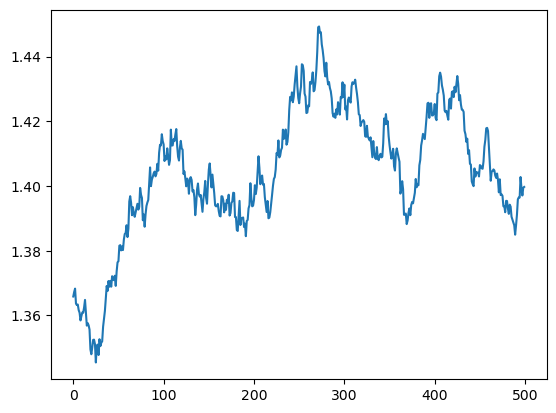

In [5]:
plt.plot(afluct)
plt.show()

# Plots

In [38]:
Nadapt_max = 50000
Nadapt_min = 10000
Ncheck = 5000
Nrepeat = 320
sigma = 1.5
theta_eta = 3.

delta_a = 0.05
Lambda = 0.9

dt = 1e-3

Nsteps_array = np.array([3, 4, 5, 6, 7])
Nsteps_array = 10**Nsteps_array

In [39]:
a_array = np.linspace(0, 1.8, 1000)

In [44]:
a_final = np.zeros((3, Nrepeat))

for i in range(3):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adapt_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    print(a_adapt.shape)

    for j in range(Nrepeat):
        a_curr = a_adapt[j, :stop_time_adapt[j]]
        a_final[i, j] = abs(a_curr[-1])    

(320, 50000)
(320, 50000)
(320, 50000)


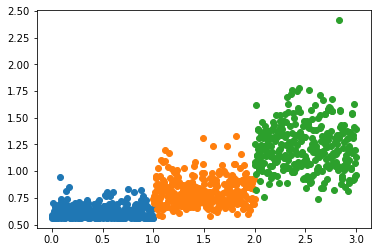

In [51]:
test = fa.Sxy_exact(sigma, a_final, theta_eta)
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i])

In [83]:
atests = np.random.randn(320)+1.36
test = fa.Iyeta_exact(sigma, atests, theta_eta)
test**2/np.var(test)/fa.Sxy_exact(sigma, atests, theta_eta)

array([3.50408255e+00, 1.81105048e+00, 3.29444794e+00, 3.13916940e+00,
       2.00874879e+00, 2.60274372e+00, 3.42709651e+00, 1.77463979e+00,
       3.01668323e+00, 2.67292478e+00, 3.42957426e+00, 3.49827341e+00,
       3.50568816e+00, 2.95515648e+00, 3.00547209e-01, 3.39314139e-02,
       3.48405403e+00, 5.12027679e-02, 2.51576238e+00, 2.42251055e+00,
       1.82364642e+00, 1.49050460e+00, 8.84113777e-01, 3.23906567e+00,
       2.87492523e+00, 3.29092496e+00, 3.33803495e+00, 3.21042730e+00,
       3.29864349e+00, 2.50840610e+00, 1.78634573e+00, 2.39152912e+00,
       3.47025267e+00, 3.05073448e+00, 2.51342092e+00, 2.09855658e+00,
       2.31568448e+00, 3.47321011e+00, 3.16977991e+00, 2.28045275e+00,
       4.28538923e-02, 1.56242040e+00, 2.19484823e+00, 3.08462045e+00,
       9.73581379e-01, 3.50501499e+00, 1.53844910e-01, 1.73697743e+00,
       3.24755713e+00, 3.37705690e+00, 1.18101359e+00, 8.46374753e-02,
       1.62353358e+00, 3.25216086e-03, 2.05400092e+00, 2.01927016e+00,
      

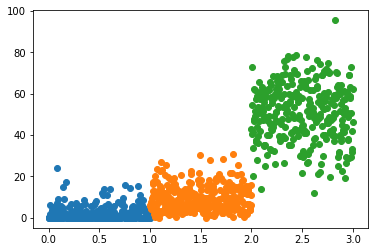

In [62]:
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i])

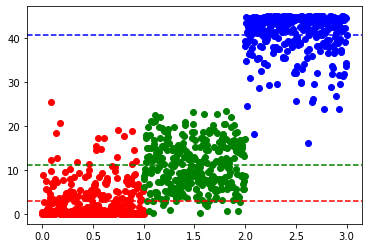

In [74]:
Nstepstests = np.array([1000,10000,100000])
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]/fa.Sxy_exact(sigma, a_final, theta_eta)
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(np.linspace(i, i+1, Nrepeat), test[i], c = colors[i])
    plt.axhline(np.mean(test[i]), linestyle = '--', c = colors[i])

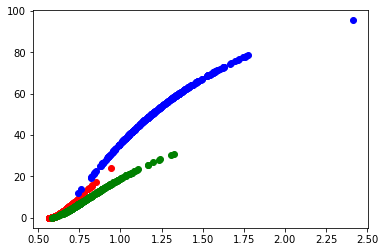

In [90]:
Nstepstests = np.array([1000,10000,100000])
test = fa.Iyeta_exact(sigma, a_final, theta_eta)
test = test**2/np.var(test, axis = 1)[..., None]
colors = ['r', 'g', 'b']
for i in range(3):
    plt.scatter(fa.Sxy_exact(sigma, a_final[i], theta_eta), test[i], c = colors[i])

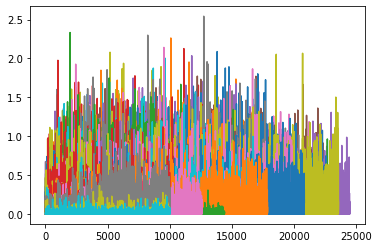

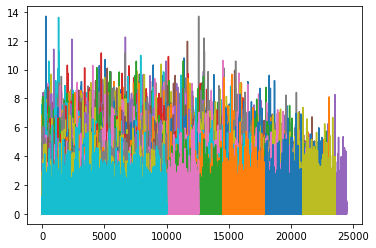

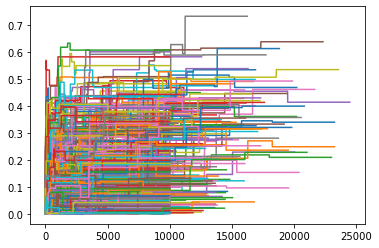

12356.796875 3185.2679438887453
0.23305895093862866 0.1507272958478341


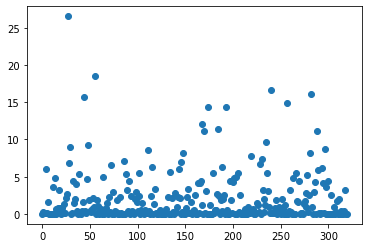

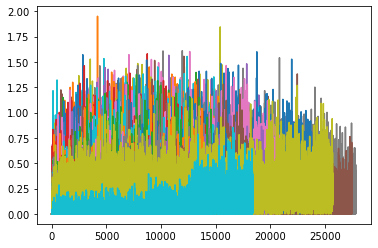

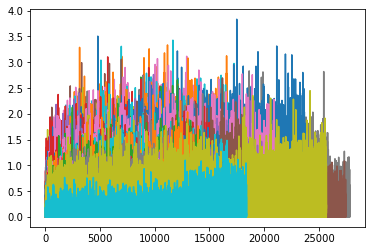

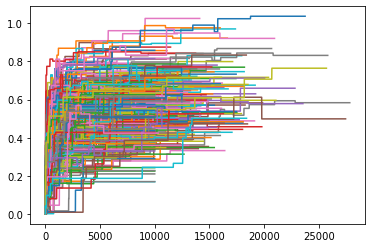

12738.165625 3415.8001214127503
0.5637532259132934 0.15205866165775367


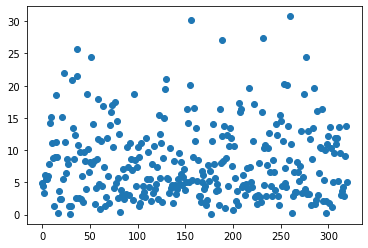

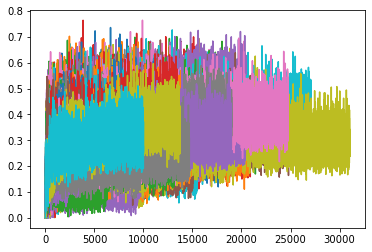

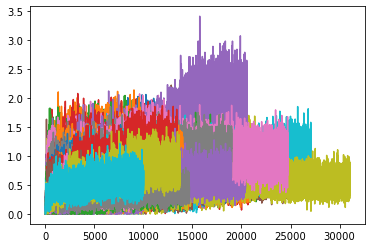

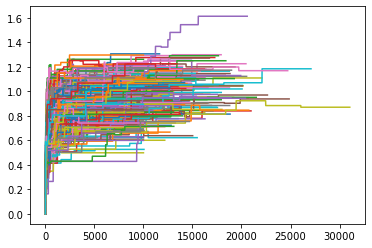

12785.24375 3556.9728144991404
0.9552042285133184 0.15957323074229568


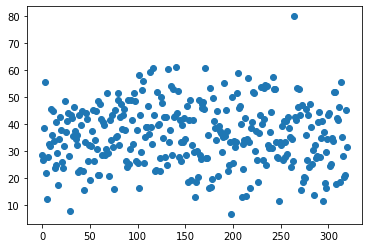

In [42]:
for i in range(3):
    Ixy_adapt = np.load(f'../data/adapt_Ixy_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    Sxy_adapt = np.load(f'../data/adapt_Sxy_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adapt_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')

    Ixy_adapt[Ixy_adapt < 0] = 0
    Sxy_adapt[Sxy_adapt < 0] = 0

    for j in range(Nrepeat):
        Ixy_curr = Ixy_adapt[j, :stop_time_adapt[j]]
        plt.plot(Ixy_curr/(Nsteps_array[i]))
    plt.show()
    
    for j in range(Nrepeat):
        Sxy_curr = Sxy_adapt[j, :stop_time_adapt[j]]
        plt.plot(Sxy_curr/(Nsteps_array[i]))
    plt.show()
    a_final = np.zeros(Nrepeat)
    for j in range(Nrepeat):
        a_curr = a_adapt[j, :stop_time_adapt[j]]
        plt.plot(abs(a_curr))
        a_final[j] = abs(a_curr[-1])
    plt.show()

    print(np.mean(stop_time_adapt), np.std(stop_time_adapt))
    print(np.mean(a_final), np.std(a_final))

    Stot = np.zeros(Nrepeat)
    Iyeta = np.zeros(Nrepeat)
    timetot = np.zeros(Nrepeat)

    for j in range(Nrepeat):
        timetot[j] = Nsteps_array[i]*stop_time_adapt[j]*dt
        Stot[j] = fa.Sxy_exact(sigma, a_final[j], theta_eta)*timetot[j]
        Iyeta[j] = fa.Ixy_exact(sigma, a_final[j], theta_eta)

    plt.scatter(range(Nrepeat),Iyeta**2/np.var(Iyeta))
    plt.show()
    print()

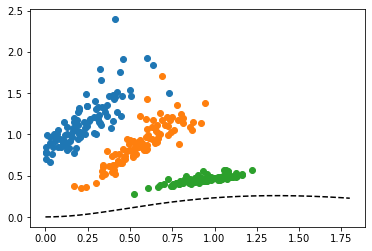

In [14]:
for i in range(3):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    stop_time_adapt = np.load(f'../data/adapt_stopTime_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_NadaptMax{Nadapt_max}_NadaptCheck{Ncheck}.npy')
    a_final = np.zeros(Nrepeat)
    L_final = np.zeros(Nrepeat)

    for j in range(Nrepeat):
        a_final[j] = abs(a_adapt[j, stop_time_adapt[j]])
        L_final[j] = L_adapt[j, stop_time_adapt[j]]

    plt.scatter(abs(a_final), L_final)

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

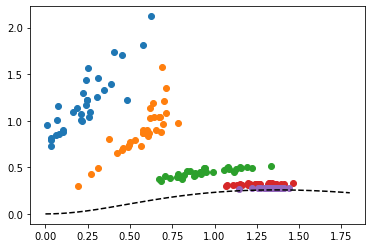

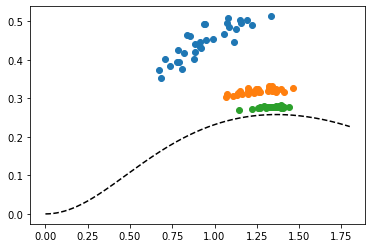

In [27]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), L_adapt[:,-1])

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

for i in range(2, 5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')
    L_adapt = np.load(f'../data/adapt_L_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), L_adapt[:,-1])

plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

0.18544768550532467
0.5175469462023764
0.945869465546001
1.262446686488209
1.3473934513609471


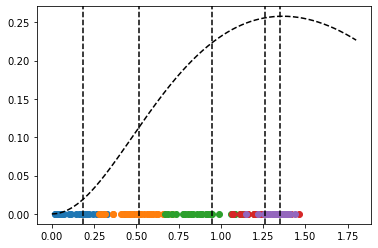

In [18]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), np.zeros(a_adapt.shape[0]))

    plt.axvline(np.mean(abs(a_adapt[:,-1])), color='k', linestyle='--')
    print(np.mean(abs(a_adapt[:,-1])))
plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

0.18544768550532467
0.5175469462023764
0.945869465546001
1.262446686488209
1.3473934513609471


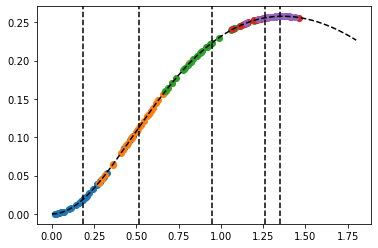

In [19]:
for i in range(5):
    a_adapt = np.load(f'../data/adapt_a_Nsteps{Nsteps_array[i]}_sigma{sigma}_theta{theta_eta}_delta{delta_a}_Lambda{Lambda}_Nadapt{Nadapt}.npy')

    plt.scatter(abs(a_adapt[:,-1]), fa.functional_exact(sigma, a_adapt[:,-1], theta_eta, Lambda))

    plt.axvline(np.mean(abs(a_adapt[:,-1])), color='k', linestyle='--')
    print(np.mean(abs(a_adapt[:,-1])))
plt.plot(a_array, fa.functional_exact(sigma, a_array, theta_eta, Lambda), 'k--')
plt.show()

# Tests

In [8]:
@njit
def simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, x0 = 0, y0 = 0, eta0 = 0):
    x = np.zeros(Nsteps, dtype=np.float64)
    y = np.zeros(Nsteps, dtype=np.float64)
    eta = np.zeros(Nsteps, dtype=np.float64)

    tau_y = theta_y * tau_x
    tau_eta = theta_eta * tau_x
    sqtau_x = np.sqrt(dt/tau_x)
    sqtau_y = np.sqrt(dt/tau_y)
    sqtau_eta = np.sqrt(dt/tau_eta)

    x[0] = x0
    y[0] = y0
    eta[0] = eta0


    for t in range(Nsteps-1):
        y[t + 1] = y[t] + dt * (-y[t] + a * x[t])/tau_y + np.random.randn() * sqtau_y
        x[t + 1] = x[t] + dt * (-x[t] + sigma * eta[t])/tau_x + np.random.randn() * sqtau_x
        eta[t + 1] = eta[t] + dt * (-eta[t])/tau_eta + np.random.randn() * sqtau_eta
        
        
    return x, y, eta

In [120]:
@njit
def cov_matrix(sigma, theta_eta, a):
    theta = 1 + theta_eta
    offdiag = 1/2*a*(1 + theta_eta*sigma**2*(1+2*theta_eta)/theta**2)
    return np.array([[1 + theta_eta*sigma**2/theta,
                      offdiag],
                     [offdiag,
                      1 + a*offdiag]])

@njit
def probability_xy(x, y, det, cov_inv):
    return np.exp(-0.5 * (x**2 * cov_inv[0,0] + y**2 * cov_inv[1,1] + 2*x*y*cov_inv[0,1])) / (2*np.pi*np.sqrt(det))

@njit
def probability_x(x, cov):
    return np.exp(-0.5 * (x**2 / cov[0,0])) / (np.sqrt(2*np.pi*cov[0,0]))

@njit
def probability_y(y, cov):
    return np.exp(-0.5 * (y**2 / cov[1,1])) / (np.sqrt(2*np.pi*cov[1,1]))

@njit
def find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)


    mutual_trajectory = np.zeros(Nsteps, dtype=np.float64)

    for t in range(Nsteps):
        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        mutual_trajectory[t] = np.log(pjoint_curr / (px_curr * py_curr))

    return mutual_trajectory, x, y

@njit
def find_Axy(sigma, theta_eta, a):
    theta = 1 + theta_eta

    den = (4 + a**2)*theta**4 + 2*(2+a**2)*theta_eta*theta**3*sigma**2
    den += a**2*theta_eta**2*(theta + theta_eta)*sigma**4

    num1 = 4*theta**4 + a**2*(theta**4 + 2*(theta_eta + theta_eta**2)**2*sigma**2 - theta_eta**2*(theta + theta_eta)*sigma**4)
    num2 = 2*a*theta_eta*theta*sigma**2*(-1+theta_eta**2-theta_eta*sigma**2)

    return np.array([[num1/den, - num2/den],
                     [- a, 1]])

@njit
def find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, tau_x = 1, theta_y = 1, Nburn = 1000000):
    x0, y0, eta0 = simulate_xyeta(Nburn, dt, sigma, a, theta_eta, tau_x, theta_y)
    x, y, _ = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0[-1], y0[-1], eta0[-1])
    x0 = None
    y0 = None

    Amat = find_Axy(sigma, theta_eta, a)

    Sx_traj = np.zeros(Nsteps - 1, dtype = np.float64)
    Sy_traj = np.zeros(Nsteps - 1, dtype = np.float64)

    for t in range(Nsteps-1):
        Deltax = x[t+1] - x[t]
        Deltay = y[t+1] - y[t]
        Stratx = 1/2*(x[t+1] + x[t])
        Straty = 1/2*(y[t+1] + y[t])
        Sx_traj[t] = (-Amat[0,0]*Stratx - Amat[0,1]*Straty)*Deltax/dt
        Sy_traj[t] = (-Amat[1,0]*Stratx - Amat[1,1]*Straty)*Deltay/dt

        # Sx_traj[t], Sy_traj[t] = -np.dot(Amat, 1/2*np.array([x[t] + x[t+1] , y[t] + y[t+1]]))*np.array([x[t+1] - x[t] , y[t+1] - y[t]])

    return Sx_traj, Sy_traj

@njit
def find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0, y0, eta0, tau_x = 1, theta_y = 1):
    x, y, eta = simulate_xyeta(Nsteps, dt, sigma, a, theta_eta, tau_x, theta_y, x0, y0, eta0)

    Amat = find_Axy(sigma, theta_eta, a)
    cov = cov_matrix(sigma, theta_eta, a)
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)

    Sxy = 0.
    Ixy = 0.

    for t in range(Nsteps-1):
        Delta_x = x[t+1] - x[t]
        Delta_y = y[t+1] - y[t]
        Strat_x = 1/2*(x[t+1] + x[t])
        Strat_y = 1/2*(y[t+1] + y[t])

        Sxy += -2*(Amat[0,0]*Strat_x + Amat[0,1]*Strat_y)*Delta_x/dt
        Sxy += -2*(Amat[1,0]*Strat_x + Amat[1,1]*Strat_y)*Delta_y/dt

        pjoint_curr = probability_xy(x[t], y[t], det, cov_inv)
        px_curr = probability_x(x[t], cov)
        py_curr = probability_y(y[t], cov)
        Ixy += np.log(pjoint_curr / (px_curr * py_curr))

    return -(1 - Lambda)*Sxy/(Nsteps - 1) + Lambda*Ixy/(Nsteps - 1), x[-1], y[-1], eta[-1]

In [148]:
@njit
def adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.01,
                      a_init = 0., tau_x = 1, theta_y = 1, Nburn = 100000):
    
    x0_burn, y0_burn, eta0_burn = simulate_xyeta(Nburn, dt, sigma, a_init, theta_eta, tau_x, theta_y)
    x0 = x0_burn[-1]
    y0 = y0_burn[-1]
    eta0 = eta0_burn[-1]

    x0_burn = None
    y0_burn = None
    eta0_burn = None

    L_adapt = np.zeros(Nadapt, dtype = np.float64)
    a_adapt = np.zeros(Nadapt, dtype = np.float64)
    L_adapt[0] = 0.
    a_adapt[0] = a_init

    for idx_adapt in range(1, Nadapt):
        a_bar = a_adapt[idx_adapt - 1] + delta_a * np.random.randn()
        L_bar, x0, y0, eta0 = find_functional(Nsteps, dt, sigma, a_bar, theta_eta, Lambda, x0, y0, eta0, tau_x, theta_y)

        if L_bar > L_adapt[idx_adapt - 1]:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        elif np.random.rand() < p_acc:
            a_adapt[idx_adapt] = a_bar
            L_adapt[idx_adapt] = L_bar
        else:
            a_adapt[idx_adapt] = a_adapt[idx_adapt - 1]
            L_adapt[idx_adapt] = L_adapt[idx_adapt - 1]

    return a_adapt, L_adapt

In [182]:
%%time

Nsteps = int(1e5)
Nadapt = 5000
sigma = 1.7
theta_eta = 1.2
delta_a = 0.05

Lambda = 0.9

dt = 1e-3

a_adapt, L_adapt = adaptive_dynamics(Nadapt, Nsteps, dt, sigma, theta_eta, Lambda, delta_a, p_acc = 0.00)
a_adapt = abs(a_adapt)

CPU times: user 29.3 s, sys: 396 ms, total: 29.7 s
Wall time: 30.2 s


0.8729501753128484


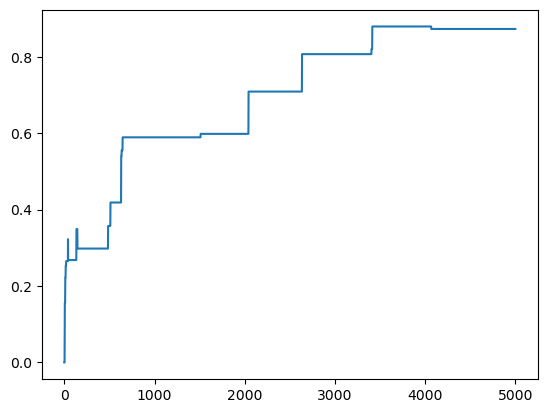

In [183]:
plt.plot(a_adapt)
print(a_adapt[-1])

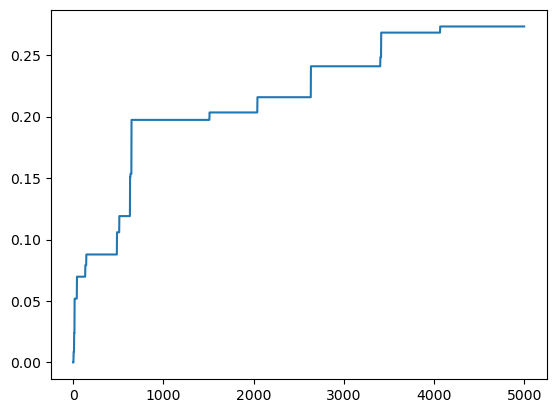

In [184]:
plt.plot(L_adapt)

In [110]:
Nsteps = int(5e5)
sigma = 0.63
theta_eta = 3.2
a = 9.6

Lambda = 0.9

dt = 1e-3

find_functional(Nsteps, dt, sigma, a, theta_eta, Lambda, x0 = 0., y0 = 0., eta0 = 0., tau_x = 1, theta_y = 1)

-4.466689688205942

In [111]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 3.2
a = 9.6
dt = 1e-3
Sx_traj, Sy_traj = find_Sxy_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [100]:
Sx_traj.mean(), Sy_traj.mean()

(-0.043062922122522655, 24.687403456573062)

In [84]:
Nsteps = int(5e7)
sigma = 0.63
theta_eta = 1.2
a = 13.1
dt = 1e-4

MI_traj, xMI, yMI = find_mutual_traj(Nsteps, dt, sigma, a, theta_eta, Nburn = 100000)

In [85]:
MI_traj.mean()

0.39543734152677096

In [74]:
find_Axy(sigma, theta_eta, a)

array([[ 8.20845124e-01,  1.65803590e-04],
       [-1.31000000e+01,  1.00000000e+00]])